**Tutorial 8 - Markov Chain Monte Carlo**

In this tutorial we will learn how to construct a basic Metropolis-Hastings Markov Chain sampler and apply it to supernova data.


In [42]:
# 1) Make a Metropolis-Hastings stepping function.
#
# The function should take the following inputs 
# x - the current position in parameter space
# loglike - the value of the log of the likelihood 
#           evaluated at x
# loglike_func - a function that returns to log of the 
#            likelihood given a position in parameters space
# proposal_func - a proposal function that takes a position in 
#                  parameter space and proposes another
#
# The function should return the updated position, the updated 
# loglike and a boolean that is True if the proposed step was 
# accepted and False if it wasn't. 
# You can assume the proposal function is symmetric.

import pandas as pa
import numpy as np
import matplotlib.pyplot as plt
import random

def MH_step(old_x, old_loglike, loglike_func,proposal_func) : 
    new_x = proposal_func(old_x)
    
    if new_x[1] < 0 or new_x[1] > 1 : 
        result = False 
        return old_x, old_loglike, result
    
    new_loglike = loglike_func(new_x)
    alpha = np.exp(new_loglike - old_loglike)
    val= np.random.uniform(0.,1.)
    
    if val > 1. : 
        result = True
        return new_x, new_loglike, result
    else : 
        if val < alpha : 
            result = True
            return new_x, new_loglike, result
        else : 
            result = False
            return old_x, old_loglike, result
        


In [43]:
# 2) Complete this code for a Gaussian proposal function class

class gaussian_transfer_function :
    
    ## This part is the constructor and 
    ## sets the internal information in the object
    # that is declared with
    # "func = gaussian_transfer_function(sigma_vector)"
    def __init__(self, sigma):
        self.n = len(sigma)
        self.s = sigma
    ##  This part defines what happens when 
    ##  you do "y = func(x)"
    ##  This should return a new point
    def __call__(self,x):
        return np.random.normal(x,self.s)


In [44]:
# 3) Make a Gaussian likelihood class of the form

#class LogGaussianLikelihood :
#    def __init__(self,y_data,x_data,y_model,sigma):
#    
#         store the data, model and errors in the object
#         The function y_model(params,x_data) will return the 
#         predicted value for y to be compared to y_data
#
#    def __call__(self,params):
#         
#        Using the stored data and model to calculate 
#        the log of the Gaussian likelihood and return 
#        its value.
#        

In [45]:
class LogGaussianLikelihood : 
    def __init__(self, y_data, x_data, y_model, sigma):
        self.x = x_data
        self.y = y_data
        self.y_model = y_model
        self.s = sigma
    def __call__(self,params) :
        return -0.5*np.sum(((self.y-self.y_model(params,self.x))/self.s)**2) 

4) Write a function that returns the distance modulus with 
signature def mu_model(p,z). 

parameters p are 

p[0] is the absolute magnitude normalization 

p[1] is omega_matter.  

Use the library function 
astropy.cosmology.FlatLambdaCDM.luminosity_distance(z).value 
to calculate the luminosity distance.


In [46]:
import astropy.cosmology as cosmo

def mu_model(p, z) : 
    universe = cosmo.FlatLambdaCDM(H0=70.,Om0=p[1])
    lum_dist = universe.luminosity_distance(z).value
    mu = 5.*np.log10(lum_dist) + p[0]
    return mu 

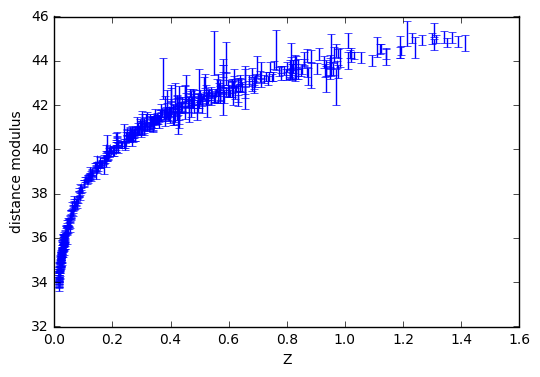

In [47]:
# Read in the supernova data
#
data = pa.read_csv("C:\\Users\\utente\\Desktop\\SCPUnion2.1_mu_vs_z.txt",sep='\t',comment='#')

z = data['redshift']
mu = data['dist_mod']
mu_err = data['dist_mod_error']

plt.errorbar(z,mu,yerr=mu_err,fmt='|')
plt.xlabel('Z')
plt.ylabel('distance modulus')
plt.show()

The acceptance fraction is 17.59 %


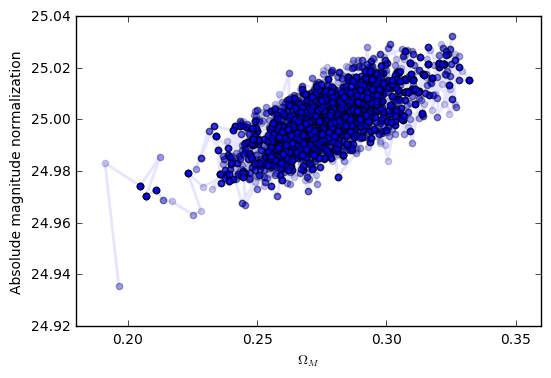

In [48]:
# 5) 
## Make an instance of LogGaussianLikelihood with the data.
## Call it loglike_func

%matplotlib inline 

loglike_func = LogGaussianLikelihood(mu,z, mu_model, mu_err)

## Make an instance of gaussian_transfer_function

gt_func = gaussian_transfer_function([0.05,0.005])

## Set up the initial point p[] and its log likelihood 
## using  loglike_func(p)

p = [25,0.2]
p_loglike = loglike_func(p)

## Make an MCMC loop 1000 steps or more long and make a scatter plot of 
## the chain.  Record the acceptance fraction.
n_step = 10000
omegaM = np.empty(n_step)
mag = np.empty(n_step)
n_true = 0

for i in range(n_step) :
    p, p_loglike, step = MH_step(p, p_loglike, loglike_func, gt_func)
    mag[i] = p[0]
    omegaM[i] = p[1]
    if step == True : 
        n_true += 1 

print("The acceptance fraction is " + str(100*n_true/n_step) + " %")

plt.plot(omegaM,mag,alpha = 0.1, zorder = 1, lw =2, color = 'blue')
plt.scatter(omegaM,mag, alpha = 0.2, zorder =2)
plt.xlabel("$\Omega_{M}$")
plt.ylabel("Absolude magnitude normalization")
plt.show()


6) Make historgrams of the two parameters.

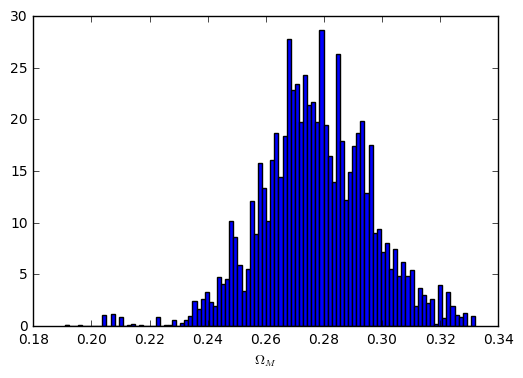

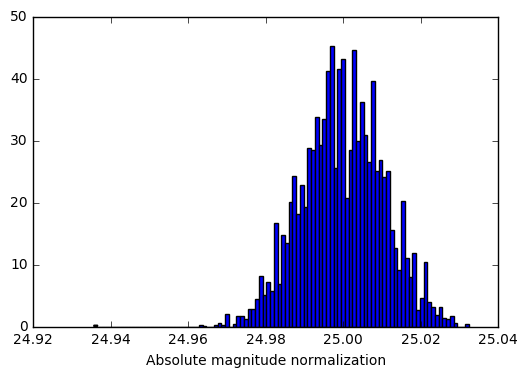

In [49]:
plt.hist(omegaM, bins = int(np.sqrt(len(omegaM))), edgecolor = 'black', normed = True)
plt.xlabel("$\Omega_{M}$")
plt.show()

plt.hist(mag,bins = int(np.sqrt(len(mag))), edgecolor = 'black', normed = True)
plt.xlabel("Absolute magnitude normalization")
plt.show()

7) Use numpy.histogram2d() to make a 2 dimensional of the chain.

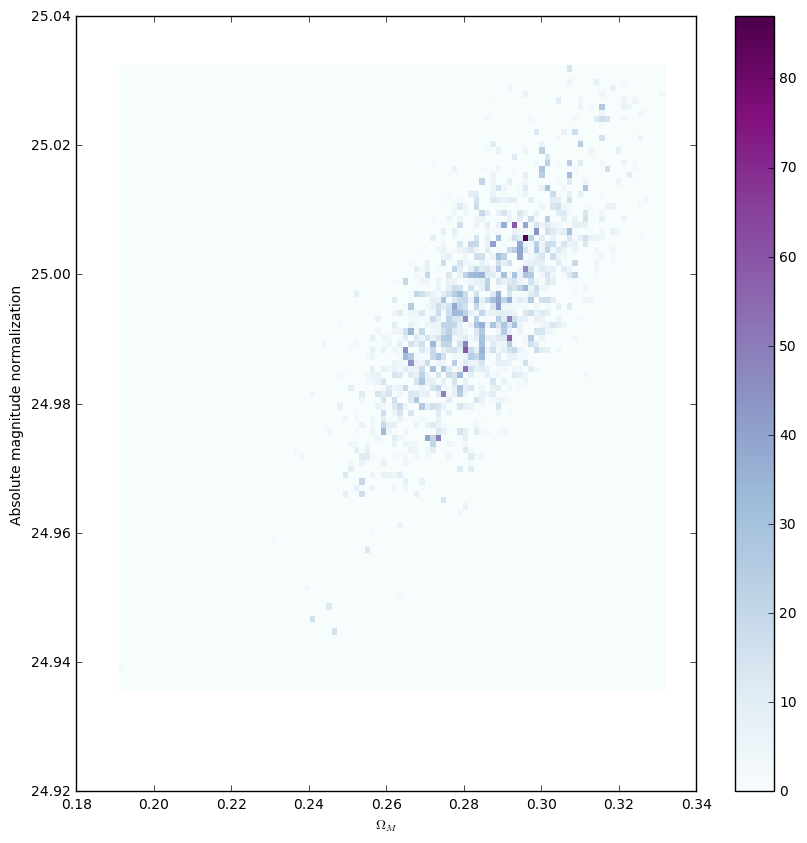

In [50]:
plt.figure(figsize = (10,10))
H, xedges, yedges = np.histogram2d(omegaM, mag, bins = (int(np.sqrt(len(omegaM))), int(np.sqrt(len(mag)))))
X,Y = np.meshgrid(xedges,yedges)
plt.pcolormesh(X,Y,H)
plt.colorbar()
plt.set_cmap('BuPu')
plt.xlabel('$\Omega_{M}$')
plt.ylabel('Absolute magnitude normalization')
plt.show()

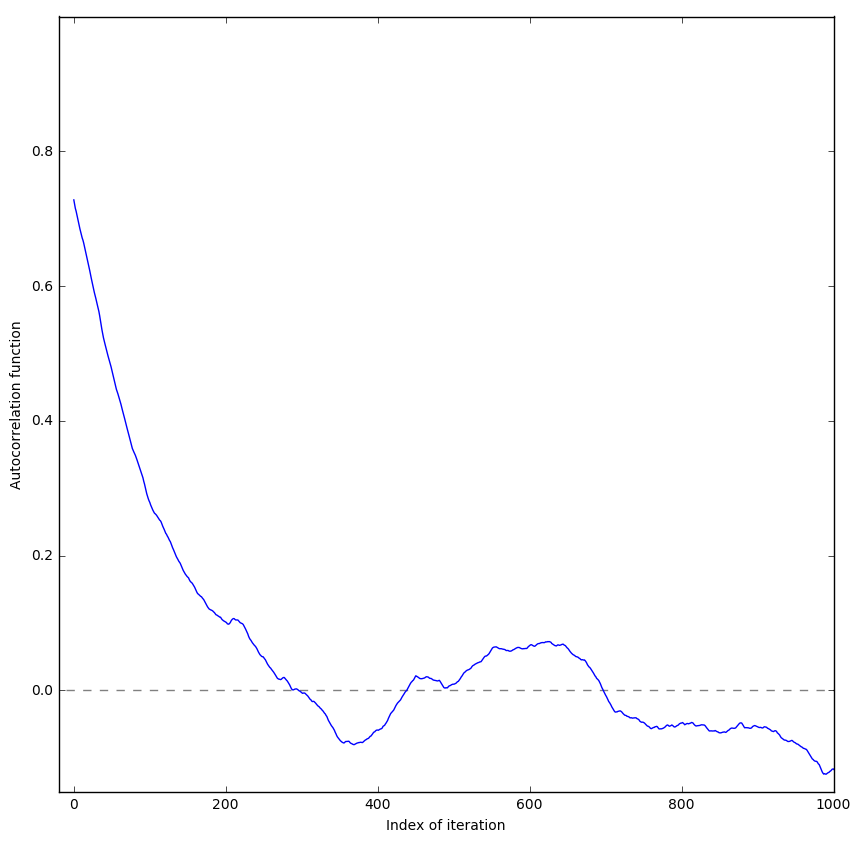

In [51]:
## 8) Use this function to estimate the correlation length 
## of your chain. Plot the autocorrelation function for 
## lag zero to a few hundred.
def corrfunction(x,y):
    '''
    This function calculates the correlation coefficient 
    as a function of lag between 
    '''
    xc = x - np.mean(x)
    yc = y - np.mean(y)
    
    N = len(x)
    out = np.empty(N-2)
    stdx = np.std(xc)
    stdy = np.std(yc)

    for i in range(N-2) :
        xt = xc[0:N-i]
        yt = yc[i:N]
        if(stdx == 0 or stdy == 0):  ## this can happen for last elements
            out[i] = 0
        else :
            out[i] = np.mean(xt*yt)/stdx/stdy

    return out

corr_lenght = corrfunction(omegaM,mag)
plt.figure(figsize = (10,10))
x = [-10,10000]
y = [0,0]
plt.plot(x,y,ls = '--', color = 'gray')
plt.plot(corr_lenght, alpha = 1)
plt.axis([-20,1000,-0.15,1])
plt.xlabel("Index of iteration")
plt.ylabel("Autocorrelation function")
plt.show()



8) Calculate the mean, variance and covariance of the parameters.

In [52]:
print("The mean value of Omega_M is " + str(np.mean(omegaM)) + " and its variance is " + str(np.var(omegaM)))
print("The mean value of the absolute magnitude normalization is " + str(np.mean(mag)) + " and its variance is " + str(np.var(mag)))

cov = np.cov(omegaM,mag)
par_mat = np.array(([[omegaM],[mag]]))
for i in range(2) : 
    for j in range(2) : 
        cov[i][j] = cov[i][j]/(np.std(par_mat[i])*np.std(par_mat[j]))
        
print("Their correlation coefficient is " + str(cov[0][1]))


The mean value of Omega_M is 0.277312961001 and its variance is 0.00035269883877
The mean value of the absolute magnitude normalization is 24.9998220928 and its variance is 0.000112013489914
Their correlation coefficient is 0.727935085442
